In [1]:
import os
import sys
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'src'))
from database import DB
from analysis import MLP, xyFeature

In [2]:
db = DB()
db.initialise()

temp_df = db.get_table('view_set_match_info_concat')

In [3]:
df = temp_df[['league_name', 'year', 'season', 'date', 'set_number', 'team_1', 'team_2', 'corresponding_team', 'tiebreaker', 'match_round', 'wdl', 'side', 'team_kills', 'team_deaths', 'team_dragon_kills', 'team_total_gold']]
df = df.dropna(subset=['wdl', 'side'])

In [4]:
cat_cols = ['side']
cont_cols = ['team_kills', 'team_deaths', 'team_dragon_kills', 'team_total_gold']
y_col = ['wdl']

In [5]:
xy = xyFeature(df, cat_cols, cont_cols, y_col)
cats, conts, y = xy.prepare_XY()
emb_szs, n_cont, out_sz = xy.get_size()

In [6]:
torch.manual_seed(69)
model = MLP(emb_szs, n_cont, out_sz, [200, 100], p=0.5)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [7]:
#batch_size = temp_df.shape[0]
train_size = temp_df[temp_df['year']!=2020].shape[0]
val_size = temp_df[temp_df['year']==2020].shape[0] // 2
test_size = temp_df[temp_df['year']==2020].shape[0] // 2

cat_train = cats[:train_size]
con_train = conts[:train_size]
y_train = y[:train_size]

cat_valid = cats[train_size: train_size+val_size]
con_valid = conts[train_size: train_size+val_size]
y_valid = y[train_size: train_size+val_size]

cat_test = cats[train_size+val_size: train_size+val_size+test_size]
con_test = conts[train_size+val_size: train_size+val_size+test_size]
y_test = y[train_size+val_size: train_size+val_size+test_size]

In [12]:
import time
start_time = time.time()

epochs = 300
costs = []

for epoch in range(epochs):
    y_pred = model.forward(cat_train, con_train)
    cost = criterion(y_pred, y_train)
    costs.append(cost)
    
    if epoch % 25 == 0:
        print(f'epoch: {epoch}, cost: {cost:.8f}')
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
print(f'Duration: {(time.time() - start_time):.0f} seconds')

epoch: 0, cost: 0.35864577
epoch: 25, cost: 0.35836831
epoch: 50, cost: 0.35854593
epoch: 75, cost: 0.35820103
epoch: 100, cost: 0.35894519
epoch: 125, cost: 0.35842443
epoch: 150, cost: 0.35780430
epoch: 175, cost: 0.35759032
epoch: 200, cost: 0.35762006
epoch: 225, cost: 0.35749429
epoch: 250, cost: 0.35707989
epoch: 275, cost: 0.35796627
Duration: 155 seconds


Text(0.5, 0, 'epoch')

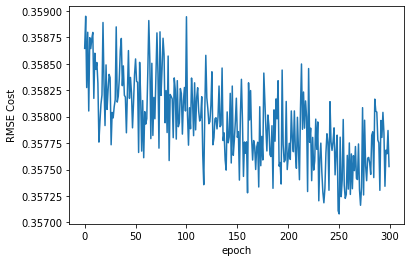

In [13]:
plt.plot(range(epochs), costs)
plt.ylabel('RMSE Cost')
plt.xlabel('epoch')

In [14]:
with torch.no_grad():
    y_pred = model(cat_test, con_test)
    cost = criterion(y_pred, y_test)
print(f'CE Loss: {cost:.8f}')
    

CE Loss: 0.34943381


In [15]:
rows = 50
correct = 0
print(f'{"Model output":36} ARGMAX    Y_test')
for i in range(rows):
    print(f'{str(y_pred[i]):36}  {y_pred[i].argmax():^7}{y_test[i]:^7}')
    if y_pred[i].argmax().item() == y_test[i]:
        correct += 1
print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct')


Model output                         ARGMAX    Y_test
tensor([1.0000e+00, 1.0853e-06])         0      0   
tensor([1.0000e+00, 1.3619e-08])         0      0   
tensor([9.9999e-01, 8.4848e-06])         0      0   
tensor([1.3128e-07, 1.0000e+00])         1      1   
tensor([1.0000e+00, 5.2962e-07])         0      0   
tensor([1.6725e-06, 1.0000e+00])         1      1   
tensor([1.8771e-07, 1.0000e+00])         1      1   
tensor([1.0000e+00, 2.3808e-06])         0      0   
tensor([0.0044, 0.9956])                 1      1   
tensor([1.0000e+00, 8.1418e-07])         0      0   
tensor([1.0000e+00, 8.1727e-07])         0      0   
tensor([5.3111e-08, 1.0000e+00])         1      1   
tensor([7.4571e-06, 9.9999e-01])         1      1   
tensor([9.9997e-01, 2.5404e-05])         0      0   
tensor([0.3296, 0.6704])                 1      0   
tensor([2.5094e-05, 9.9997e-01])         1      1   
tensor([9.9996e-01, 4.3993e-05])         0      0   
tensor([8.5526e-08, 1.0000e+00])         1   